# ✈️ AI-Driven Predictive Maintenance for Turbofan Engines
**Project:** Predicting Remaining Useful Life (RUL) of NASA Jet Engines.

**Goal:** Prevent failures by detecting degradation patterns in sensor data.

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configuration to show all columns
pd.set_option('display.max_columns', None)

In [43]:

# --- STEP 1: LOAD THE DATA ---
# Define paths (using raw strings for Windows)
zip_path = r"C:\Users\sreer\Downloads\CMAPSSData.zip"
extract_to = r"C:\Users\sreer\Downloads\CMAPSS_Extracted"

# Extract (only if not already extracted)
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Load train_FD001.txt
train_file_path = os.path.join(extract_to, 'train_FD001.txt')
df = pd.read_csv(train_file_path, sep=r'\s+', header=None)

# Name the columns
column_names = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + \
               [f's_{i}' for i in range(1, 22)]
df.columns = column_names

print("Data Loaded Successfully!")

Data Loaded Successfully!


In [2]:
df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [4]:
df.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## Check for Missing Values

In [6]:
#Check for Missing Values
missing_count= df.isnull().sum().sum()
print(f"Total missing values:{missing_count}")

Total missing values:0


In [8]:
#Identify and Drop Constant Columns (The Real Cleaning)
# 1. Calculate standard deviation for every column
std_counts = df.std()

# 2. Filter columns where standard deviation is 0 (or extremely close to 0)
constant_columns = std_counts[std_counts == 0].index.tolist()
print("Columns to be dropped (Constant values):")
print(constant_columns)

Columns to be dropped (Constant values):
['setting_3', 's_18', 's_19']


In [9]:
# 3. Drop these columns
df_clean = df.drop(columns=constant_columns)

print(f"\nNew shape after dropping constant columns: {df_clean.shape}")


New shape after dropping constant columns: (20631, 23)


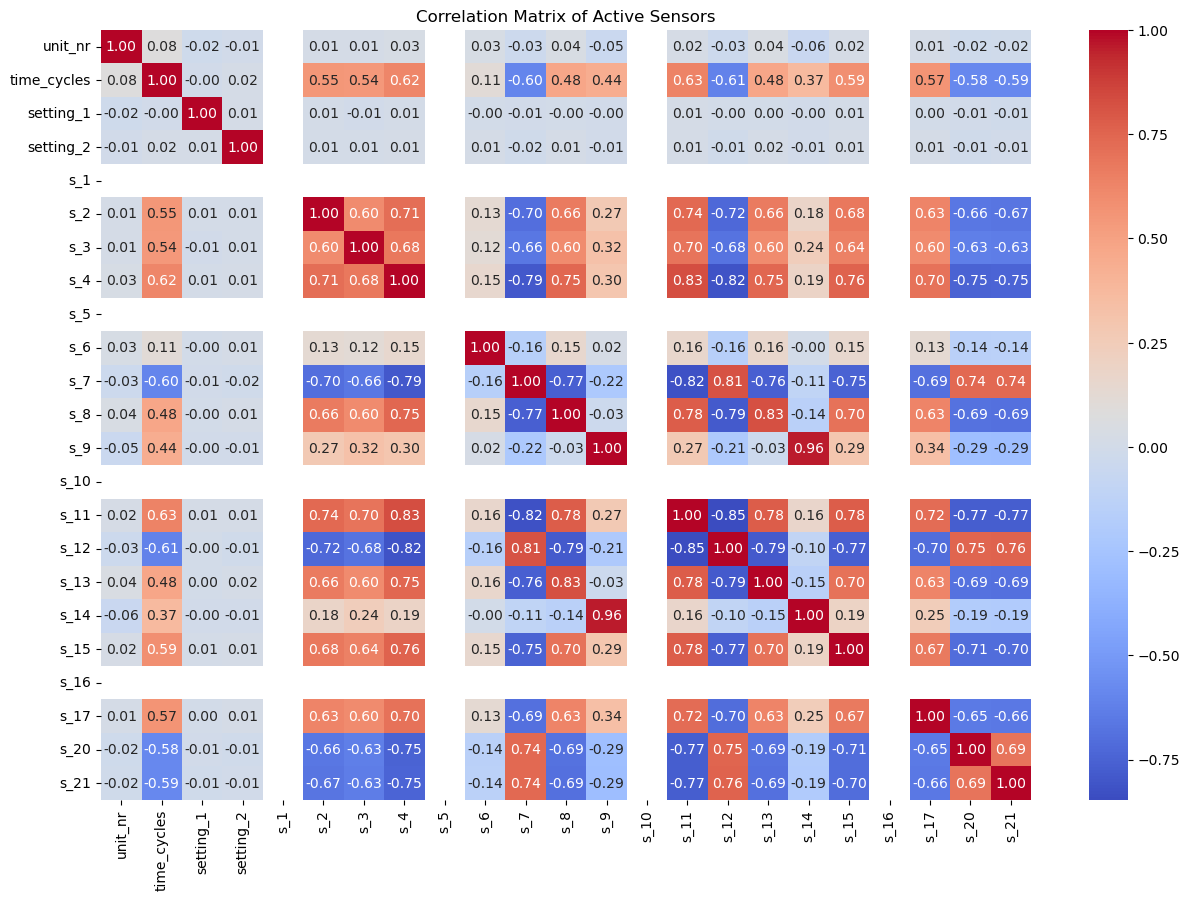

In [11]:
#Correlation Check (Optional but Recommended)

# Compute correlation matrix
corr_matrix = df_clean.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Active Sensors")
plt.show()


In [12]:
# 1. Check for Duplicate Rows
# We look for rows that are identical across ALL columns
duplicate_count = df_clean.duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    # If duplicates exist, remove them and keep the first occurrence
    df_clean = df_clean.drop_duplicates(keep='first')
    print("Duplicates removed.")
else:
    print("No duplicates found. Data is unique.")

Number of duplicate rows: 0
No duplicates found. Data is unique.


In [13]:
# 2. Check for Inconsistent Data Types (Formats)
# We expect ALL columns to be numbers (int64 or float64).
# If we see 'object', it means there is text mixed with numbers (Inconsistent Format).
print("\n--- Data Type Check ---")
print(df_clean.dtypes)

# Verification Logic:
# If any column is 'object', we force it to numeric
# (coercing errors to NaN, which we would then handle)
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        print(f"Fixing inconsistent format in column: {col}")
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
print("\nFormat check complete. All columns should be int64 or float64.")


--- Data Type Check ---
unit_nr          int64
time_cycles      int64
setting_1      float64
setting_2      float64
s_1            float64
s_2            float64
s_3            float64
s_4            float64
s_5            float64
s_6            float64
s_7            float64
s_8            float64
s_9            float64
s_10           float64
s_11           float64
s_12           float64
s_13           float64
s_14           float64
s_15           float64
s_16           float64
s_17             int64
s_20           float64
s_21           float64
dtype: object

Format check complete. All columns should be int64 or float64.


In [39]:
# --- STEP 3: LABEL ENGINEERING (Calculate RUL) ---
# Calculate the MAX time cycle for each engine (the cycle it failed)
max_cycles = df_clean.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_nr', 'max_time_cycles']

# Merge back into the main dataframe
df_clean = df_clean.merge(max_cycles, on='unit_nr', how='left')

# Calculate RUL (Max Life - Current Age)
df_clean['RUL'] = df_clean['max_time_cycles'] - df_clean['time_cycles']

# Create Classes: 0=Healthy, 1=Warning, 2=Critical
def create_label(rul):
    if rul <= 15:
        return 2  # Critical
    elif rul <= 30:
        return 1  # Warning
    else:
        return 0  # Healthy

df_clean['label'] = df_clean['RUL'].apply(create_label)
print("RUL and Labels created successfully.")

RUL and Labels created successfully.


In [40]:
# --- STEP 4: FEATURE ENGINEERING ---
# Select sensor columns
sensor_cols = [c for c in df_clean.columns if c.startswith('s_')]

# Calculate Rolling Mean and Std Dev (Window = 5 cycles)
df_rolling = df_clean.groupby('unit_nr')[sensor_cols].rolling(window=5).mean()
df_rolling.columns = [f"{col}_mean" for col in sensor_cols]

# Drop the multi-index created by groupby to merge back easily
df_rolling = df_rolling.reset_index(drop=True)

# Join with main data
df_final = pd.concat([df_clean.reset_index(drop=True), df_rolling], axis=1)

# Drop rows with NaNs (the first 5 cycles of each engine)
df_final = df_final.dropna()
print(f"Feature Engineering Complete. New Shape: {df_final.shape}")

Feature Engineering Complete. New Shape: (20231, 31)


Renaming sensor columns...
Renaming Complete.

Current Columns in DataFrame:
['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 's_1', 'LPC_Outlet_Temp', 'HPC_Outlet_Temp', 'LPT_Outlet_Temp', 's_5', 's_6', 'HPC_Outlet_Pressure', 'Physical_Fan_Speed', 'Physical_Core_Speed', 's_10', 'HPC_Static_Pressure', 'Fuel_Flow_Ratio', 'Corrected_Fan_Speed', 'Corrected_Core_Speed', 'Bypass_Ratio', 's_16', 'HPC_Outlet_Static_Pressure', 'HPT_Coolant_Bleed', 'LPT_Coolant_Bleed']


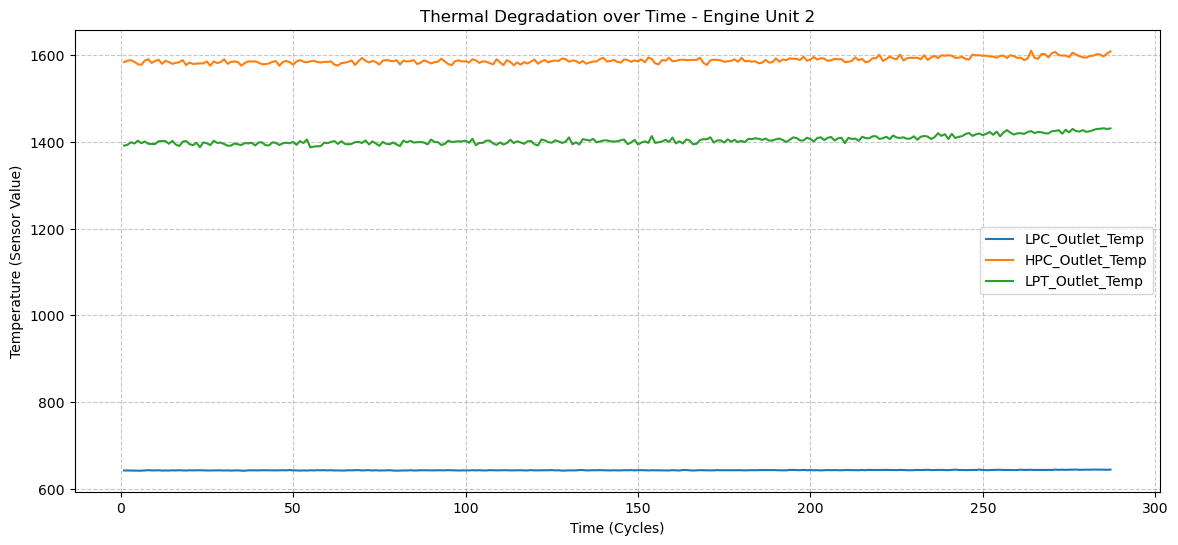

In [15]:
# 1. Define the mapping (Sensor Code -> Engineering Name)
sensor_names = {
    's_2': 'LPC_Outlet_Temp',
    's_3': 'HPC_Outlet_Temp',
    's_4': 'LPT_Outlet_Temp',
    's_7': 'HPC_Outlet_Pressure',
    's_8': 'Physical_Fan_Speed',
    's_9': 'Physical_Core_Speed',
    's_11': 'HPC_Static_Pressure',
    's_12': 'Fuel_Flow_Ratio',
    's_13': 'Corrected_Fan_Speed',
    's_14': 'Corrected_Core_Speed',
    's_15': 'Bypass_Ratio',
    's_17': 'HPC_Outlet_Static_Pressure',
    's_20': 'HPT_Coolant_Bleed',
    's_21': 'LPT_Coolant_Bleed'
}

# 2. Check and Rename
# We only rename if 's_2' is actually in the columns (to avoid errors if you run this twice)
if 's_2' in df_clean.columns:
    print("Renaming sensor columns...")
    df_clean = df_clean.rename(columns=sensor_names)
    print("Renaming Complete.")
else:
    print("Columns appear to be already renamed (or s_2 is missing).")

# 3. Verify the current columns
print("\nCurrent Columns in DataFrame:")
print(df_clean.columns.tolist())
# Select one engine to visualize (e.g., Engine Unit #2)
engine_id = 2
subset = df_clean[df_clean['unit_nr'] == engine_id]

# Thermal Sensors we renamed earlier
thermal_sensors = ['LPC_Outlet_Temp', 'HPC_Outlet_Temp', 'LPT_Outlet_Temp']

# Create a Line Plot
plt.figure(figsize=(14, 6))
for sensor in thermal_sensors:
    # We normalized the data just for plotting so they fit on one chart
    # (Or we can plot raw values if they are close in range)
    plt.plot(subset['time_cycles'], subset[sensor], label=sensor)

plt.xlabel("Time (Cycles)")
plt.ylabel("Temperature (Sensor Value)")
plt.title(f"Thermal Degradation over Time - Engine Unit {engine_id}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

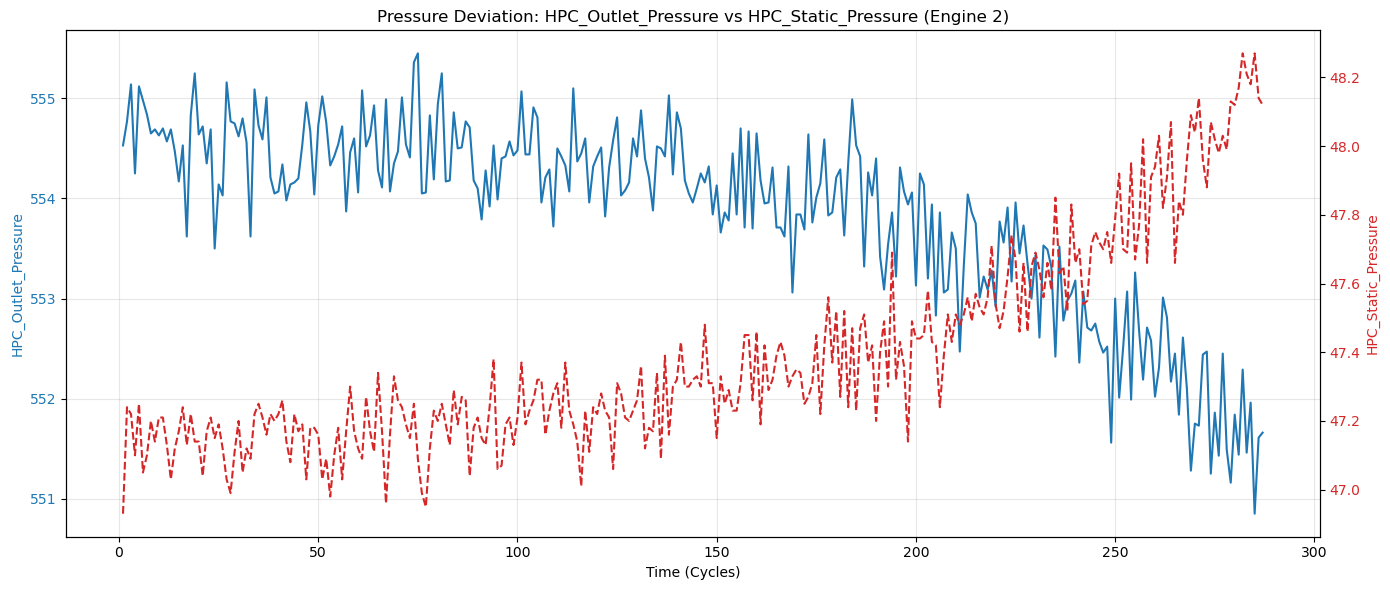

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select an engine (Unit 2 usually has good data)
engine_id = 2
subset = df_clean[df_clean['unit_nr'] == engine_id]

# Define Pressure Sensors (Check if they exist in your data first)
p1 = 'HPC_Outlet_Pressure' # s_7
p2 = 'HPC_Static_Pressure' # s_11

if p1 in subset.columns and p2 in subset.columns:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot First Pressure Sensor (Left Axis)
    color = 'tab:blue'
    ax1.set_xlabel('Time (Cycles)')
    ax1.set_ylabel(p1, color=color)
    ax1.plot(subset['time_cycles'], subset[p1], color=color, label=p1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Plot Second Pressure Sensor (Right Axis)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel(p2, color=color)  # we already handled the x-label with ax1
    ax2.plot(subset['time_cycles'], subset[p2], color=color, linestyle='--', label=p2)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f"Pressure Deviation: {p1} vs {p2} (Engine {engine_id})")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
else:
    print(f"Columns {p1} or {p2} not found. Did you rename them correctly?")

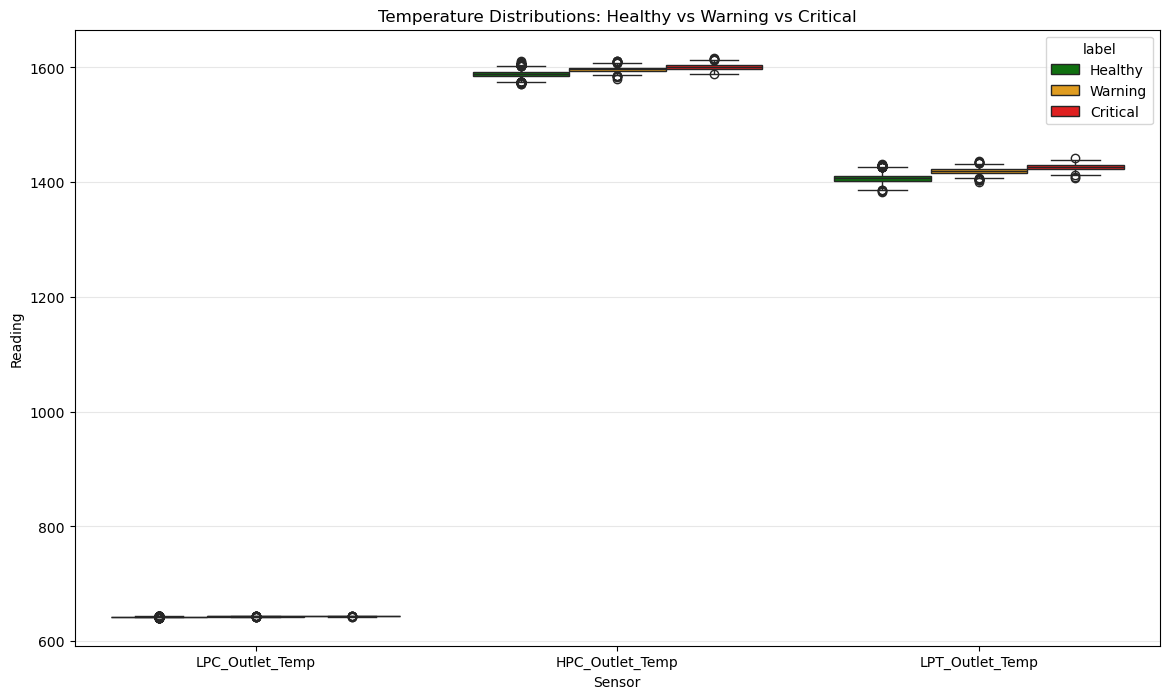

In [21]:
# Melt the dataframe to make it easy to plot multiple sensors at once
thermal_data = df_clean.melt(id_vars=['label'], 
                             value_vars=thermal_sensors, 
                             var_name='Sensor', 
                             value_name='Reading')

# Replace label numbers with names for the chart
thermal_data['label'] = thermal_data['label'].map({0: 'Healthy', 1: 'Warning', 2: 'Critical'})

plt.figure(figsize=(14, 8))
sns.boxplot(x='Sensor', y='Reading', hue='label', data=thermal_data, palette=['green', 'orange', 'red'])
plt.title("Temperature Distributions: Healthy vs Warning vs Critical")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Scaler saved as 'engine_scaler.pkl' (Don't forget this!)
Columns in dataframe: ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 's_1', 'LPC_Outlet_Temp', 'HPC_Outlet_Temp', 'LPT_Outlet_Temp', 's_5', 's_6', 'HPC_Outlet_Pressure', 'Physical_Fan_Speed', 'Physical_Core_Speed', 's_10', 'HPC_Static_Pressure', 'Fuel_Flow_Ratio', 'Corrected_Fan_Speed', 'Corrected_Core_Speed', 'Bypass_Ratio', 's_16', 'HPC_Outlet_Static_Pressure', 'HPT_Coolant_Bleed', 'LPT_Coolant_Bleed', 'RUL', 'label', 'max_time_cycles']

Label distribution:
label
0    17531
2     1600
1     1500
Name: count, dtype: int64


C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\2348556990.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[df_clean['label']==0][target_sensor], shade=True, color='green', label='Healthy', alpha=0.4)
C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\2348556990.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[df_clean['label']==1][target_sensor], shade=True, color='orange', label='Warning', alpha=0.4)
C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\2348556990.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[df_clean['label']==2][target_sensor], shade=True, color='red', label='Cr

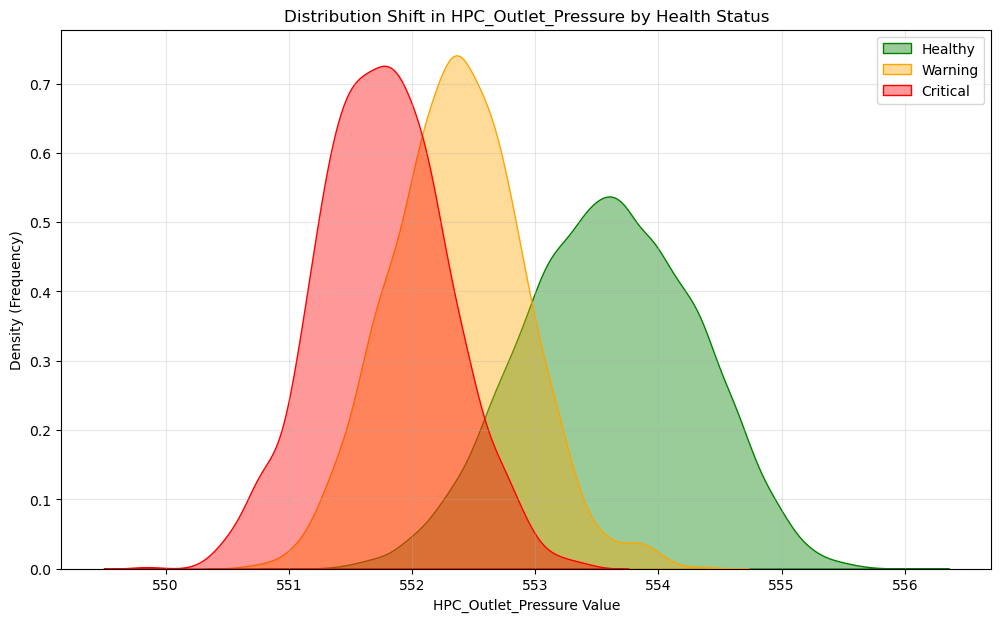

In [41]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# --- STEP 5: SCALING & SAVING ---
# Define features (Raw sensors + Rolling means)
features = [c for c in df_final.columns if c.startswith('s_')]
X = df_final[features]
y = df_final['label']

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# !!! CRITICAL: Save the Scaler !!!
joblib.dump(scaler, 'engine_scaler.pkl')
print("Scaler saved as 'engine_scaler.pkl' (Don't forget this!)")
# 1. Calculate the MAX cycle for each engine (when it failed)
max_cycles_per_unit = df_clean.groupby('unit_nr')['time_cycles'].transform('max')

# 2. Calculate RUL (Remaining Useful Life)
df_clean['RUL'] = max_cycles_per_unit - df_clean['time_cycles']

# 3. Create the Labels (0=Healthy, 1=Warning, 2=Critical)
def create_label(rul):
    if rul <= 15:
        return 2  # Critical
    elif rul <= 30:
        return 1  # Warning
    else:
        return 0  # Healthy

df_clean['label'] = df_clean['RUL'].apply(create_label)

# 4. Verify it exists now
print("Columns in dataframe:", df_clean.columns.tolist())
print("\nLabel distribution:")
print(df_clean['label'].value_counts())
# Select one pressure sensor to analyze deeply
target_sensor = 'HPC_Outlet_Pressure' # s_7

if target_sensor in df_clean.columns:
    plt.figure(figsize=(12, 7))
    
    # Plot KDE for each Label class
    # Healthy (0), Warning (1), Critical (2)
    sns.kdeplot(df_clean[df_clean['label']==0][target_sensor], shade=True, color='green', label='Healthy', alpha=0.4)
    sns.kdeplot(df_clean[df_clean['label']==1][target_sensor], shade=True, color='orange', label='Warning', alpha=0.4)
    sns.kdeplot(df_clean[df_clean['label']==2][target_sensor], shade=True, color='red', label='Critical', alpha=0.4)
    
    plt.title(f"Distribution Shift in {target_sensor} by Health Status")
    plt.xlabel(f"{target_sensor} Value")
    plt.ylabel("Density (Frequency)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Sensor {target_sensor} not found.")

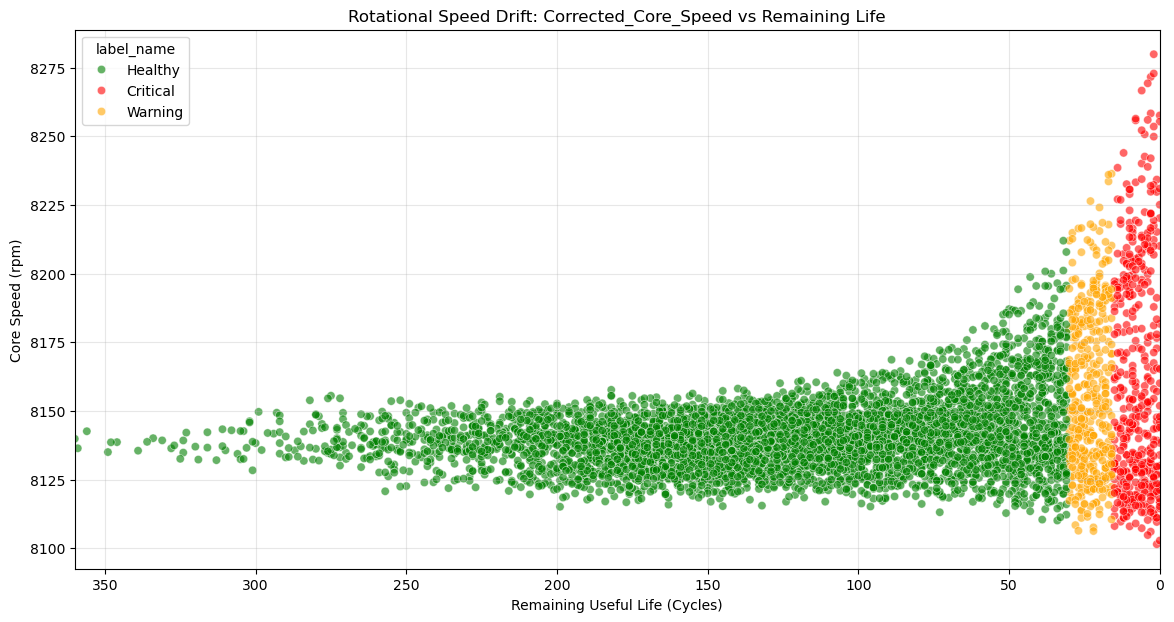

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Safety Check: Ensure Columns use the correct names ---
# We look for either the code 's_14' or the name 'Corrected_Core_Speed'
if 'Corrected_Core_Speed' in df_clean.columns:
    feature = 'Corrected_Core_Speed'
elif 's_14' in df_clean.columns:
    feature = 's_14'
else:
    feature = None
    print("Error: Could not find Sensor 14 (Core Speed) in the dataframe.")

if feature:
    plt.figure(figsize=(14, 7))
    
    # We sample the data to make the plot less crowded (optional, but good for speed)
    sample_df = df_clean.sample(frac=0.3, random_state=42)
    
    # Map labels for the legend
    sample_df['label_name'] = sample_df['label'].map({0: 'Healthy', 1: 'Warning', 2: 'Critical'})
    
    # Create Scatter Plot
    # We reverse the X-axis so it reads like a timeline (High RUL -> Low RUL)
    sns.scatterplot(x='RUL', y=feature, hue='label_name', data=sample_df, 
                    palette={'Healthy':'green', 'Warning':'orange', 'Critical':'red'}, alpha=0.6)
    
    plt.xlim(sample_df['RUL'].max(), 0) # Reverse x-axis: New engines on left, dying on right
    plt.title(f"Rotational Speed Drift: {feature} vs Remaining Life")
    plt.xlabel("Remaining Useful Life (Cycles)")
    plt.ylabel("Core Speed (rpm)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [25]:
# --- STEP 4 & 5: COMPLETE FEATURE ENGINEERING ---

# 1. Define features to roll (All sensors, excluding ID and Targets)
features_to_roll = [col for col in df_clean.columns 
                    if col not in ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 'RUL', 'label']]

print(f"Generating features for {len(features_to_roll)} sensors...")

# 2. ROLLING FEATURES (Mean & Std)
window_size = 5
df_rolling = df_clean.groupby('unit_nr')[features_to_roll].rolling(window=window_size)

# Calculate Mean
rolling_mean = df_rolling.mean().reset_index().drop(['level_1', 'unit_nr'], axis=1)
rolling_mean.columns = [f"{col}_mean" for col in rolling_mean.columns]

# Calculate Std
rolling_std = df_rolling.std().reset_index().drop(['level_1', 'unit_nr'], axis=1)
rolling_std.columns = [f"{col}_std" for col in rolling_std.columns]

# Merge into df_engineered
df_engineered = pd.concat([df_clean, rolling_mean, rolling_std], axis=1)

# Fill NaNs created by the window (using Back Fill)
df_engineered = df_engineered.groupby('unit_nr').apply(lambda x: x.bfill()).reset_index(drop=True)

print("Rolling Features created.")

# 3. DELTA FEATURES (Rate of Change)
# We calculate the difference between the current value and the value 1 cycle ago
df_delta = df_engineered.groupby('unit_nr')[features_to_roll].diff().fillna(0)
df_delta.columns = [f"{col}_delta" for col in df_delta.columns]

# 4. FINAL MERGE
df_final = pd.concat([df_engineered, df_delta], axis=1)

# 5. Verification
print("\n--- Feature Engineering Complete ---")
print(f"Original Shape: {df_clean.shape}")
print(f"Final Shape:    {df_final.shape}")
print("\nNew Columns Preview:")
print(df_final.columns.tolist()[-10:]) # Show the last 10 columns created

Generating features for 19 sensors...
Rolling Features created.

--- Feature Engineering Complete ---
Original Shape: (20631, 25)
Final Shape:    (20631, 82)

New Columns Preview:
['s_10_delta', 'HPC_Static_Pressure_delta', 'Fuel_Flow_Ratio_delta', 'Corrected_Fan_Speed_delta', 'Corrected_Core_Speed_delta', 'Bypass_Ratio_delta', 's_16_delta', 'HPC_Outlet_Static_Pressure_delta', 'HPT_Coolant_Bleed_delta', 'LPT_Coolant_Bleed_delta']


C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\160370191.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_engineered = df_engineered.groupby('unit_nr').apply(lambda x: x.bfill()).reset_index(drop=True)


In [26]:
# --- STEP 6: ENCODING AND TYPE VERIFICATION ---

# 1. Check for any non-numeric columns (Objects)
# In C-MAPSS, this should return an empty list.
object_cols = df_final.select_dtypes(include=['object']).columns

if len(object_cols) > 0:
    print(f"Found categorical text columns: {object_cols}")
    print("One-Hot Encoding them now...")
    # If we had text (e.g. 'EngineModelA'), this line would convert it to numbers
    df_final = pd.get_dummies(df_final, columns=object_cols, drop_first=True)
else:
    print("No text columns found. All features are already numeric.")

# 2. Ensure the Target Label is an Integer
# Classifiers require the target to be an integer (0, 1, 2), not a float (1.0, 2.0)
df_final['label'] = df_final['label'].astype(int)

print("\n--- Final Data Types ---")
print(df_final.dtypes.value_counts()) # Should show only float64 and int64
print("\nTarget Label Verification:")
print(df_final['label'].unique()) # Should be [0 1 2] or similar

No text columns found. All features are already numeric.

--- Final Data Types ---
float64    77
int64       5
Name: count, dtype: int64

Target Label Verification:
[0 1 2]


In [27]:
from sklearn.preprocessing import MinMaxScaler

# --- STEP 7: SCALING / NORMALIZATION ---

# 1. Separate Features and Target
# We do NOT scale the Target ('label') or the ID ('unit_nr', 'time_cycles', 'RUL')
cols_to_exclude = ['unit_nr', 'time_cycles', 'RUL', 'label']

# Identify which columns are features
feature_cols = [c for c in df_final.columns if c not in cols_to_exclude]

print(f"Scaling {len(feature_cols)} features...")

# 2. Apply Min-Max Scaling
scaler = MinMaxScaler()
df_final[feature_cols] = scaler.fit_transform(df_final[feature_cols])

# 3. Verification
print("\nScaling Complete!")
print("Check Range (Should be 0 to 1):")
print(df_final[feature_cols].describe().loc[['min', 'max']].T.head(5))

# 4. Final Look at the Data
print("\nFirst 5 rows of scaled data:")
print(df_final[feature_cols].head())

Scaling 78 features...

Scaling Complete!
Check Range (Should be 0 to 1):
                 min  max
setting_1        0.0  1.0
setting_2        0.0  1.0
s_1              0.0  0.0
LPC_Outlet_Temp  0.0  1.0
HPC_Outlet_Temp  0.0  1.0

First 5 rows of scaled data:
   setting_1  setting_2  s_1  LPC_Outlet_Temp  HPC_Outlet_Temp  \
0   0.459770   0.166667  0.0         0.183735         0.406802   
1   0.609195   0.250000  0.0         0.283133         0.453019   
2   0.252874   0.750000  0.0         0.343373         0.369523   
3   0.540230   0.500000  0.0         0.343373         0.256159   
4   0.390805   0.333333  0.0         0.349398         0.257467   

   LPT_Outlet_Temp  s_5  s_6  HPC_Outlet_Pressure  Physical_Fan_Speed  ...  \
0         0.309757  0.0  1.0             0.726248            0.242424  ...   
1         0.352633  0.0  1.0             0.628019            0.212121  ...   
2         0.370527  0.0  1.0             0.710145            0.272727  ...   
3         0.331195  0.0  1.0   

Class Counts:
label
0    17531
2     1600
1     1500
Name: count, dtype: int64


C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\956003018.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=['green', 'orange', 'red'])


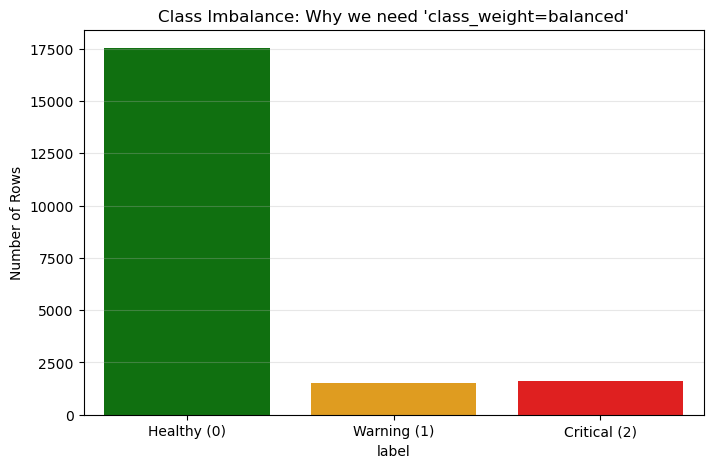


--- calculated Class Weights ---
Healthy Weight:  0.39  (Model cares less)
Warning Weight:  4.58
Critical Weight: 4.30  (Model cares MORE!)


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 8: CHECK DATA IMBALANCE ---

# 1. Count the classes
class_counts = df_final['label'].value_counts()
print("Class Counts:")
print(class_counts)

# 2. Visualize
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['green', 'orange', 'red'])
plt.xticks([0, 1, 2], ['Healthy (0)', 'Warning (1)', 'Critical (2)'])
plt.title("Class Imbalance: Why we need 'class_weight=balanced'")
plt.ylabel("Number of Rows")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Calculate the weights manually (just to see them)
# This is what the model will do internally later
total = len(df_final)
weight_0 = total / (3 * class_counts[0])
weight_1 = total / (3 * class_counts[1])
weight_2 = total / (3 * class_counts[2])

print("\n--- calculated Class Weights ---")
print(f"Healthy Weight:  {weight_0:.2f}  (Model cares less)")
print(f"Warning Weight:  {weight_1:.2f}")
print(f"Critical Weight: {weight_2:.2f}  (Model cares MORE!)")

In [29]:
from sklearn.model_selection import GroupShuffleSplit

# --- STEP 9: TRAIN / TEST SPLIT (Group-Aware) ---

# 1. Define Features (X) and Target (y)
# We exclude the 'label' (target) and metadata ('unit_nr', 'time_cycles', 'RUL')
metadata_cols = ['unit_nr', 'time_cycles', 'RUL', 'label']
feature_cols = [c for c in df_final.columns if c not in metadata_cols]

X = df_final[feature_cols]
y = df_final['label']
groups = df_final['unit_nr'] # We split based on this

# 2. Split by Groups (Engines)
# This ensures all cycles from Engine X stay together
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    train_df = df_final.iloc[train_idx]
    test_df = df_final.iloc[test_idx]

# 3. Create Final Arrays
X_train = train_df[feature_cols]
y_train = train_df['label']

X_test = test_df[feature_cols]
y_test = test_df['label']

# 4. Verification
print("--- Split Complete ---")
print(f"Training Set: {X_train.shape[0]} rows (Engines: {train_df['unit_nr'].nunique()})")
print(f"Testing Set:  {X_test.shape[0]} rows (Engines: {test_df['unit_nr'].nunique()})")

print("\nClass Distribution in Test Set:")
print(y_test.value_counts())

--- Split Complete ---
Training Set: 16561 rows (Engines: 80)
Testing Set:  4070 rows (Engines: 20)

Class Distribution in Test Set:
label
0    3450
2     320
1     300
Name: count, dtype: int64


Training Random Forest... (This might take a moment)
Training Complete.

Overall Accuracy: 0.9469

--- Classification Report ---
              precision    recall  f1-score   support

     Healthy       0.97      0.99      0.98      3450
     Warning       0.67      0.55      0.61       300
    Critical       0.89      0.88      0.89       320

    accuracy                           0.95      4070
   macro avg       0.84      0.81      0.82      4070
weighted avg       0.94      0.95      0.94      4070



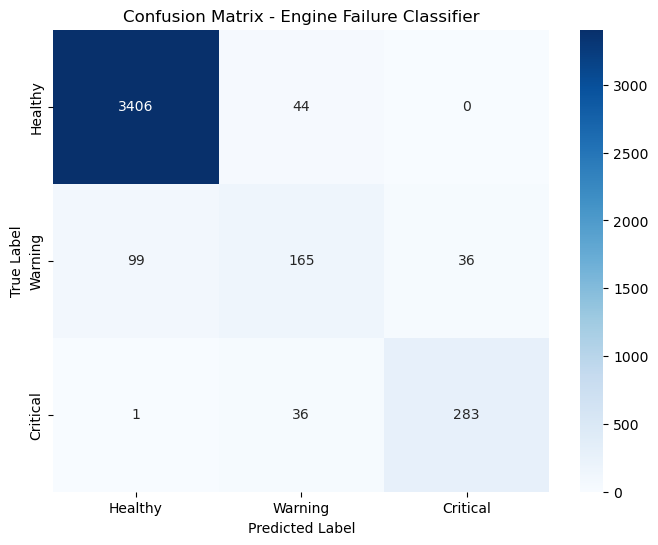

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 10: MODEL TRAINING ---

# 1. Initialize the Random Forest
# n_estimators=100: Create 100 decision trees
# class_weight='balanced': Handle the imbalance automatically
# random_state=42: Ensure we get the same result every time
rf_model = RandomForestClassifier(n_estimators=100, 
                                  class_weight='balanced', 
                                  random_state=42, 
                                  n_jobs=-1) # Use all CPU cores

print("Training Random Forest... (This might take a moment)")
rf_model.fit(X_train, y_train)
print("Training Complete.")

# 2. Make Predictions on the Test Set
y_pred = rf_model.predict(X_test)

# --- STEP 11: EVALUATION ---

# 1. Accuracy Score
print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 2. Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Warning', 'Critical']))

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Warning', 'Critical'], 
            yticklabels=['Healthy', 'Warning', 'Critical'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Engine Failure Classifier')
plt.show()

In [42]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, y, groups=df_final['unit_nr']))

X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training Engines: {len(train_idx)}")
print(f"Testing Engines: {len(test_idx)}")

Training Engines: 16241
Testing Engines: 3990


In [31]:

from sklearn.model_selection import RandomizedSearchCV, GroupKFold
import numpy as np

# --- STEP 12: HYPERPARAMETER TUNING ---

# 1. Define the Parameter Grid
# We test different sizes and depths for the forest
param_dist = {
    'n_estimators': [100, 200, 300],        # More trees = usually better but slower
    'max_depth': [10, 20, 30, None],        # Restrict depth to prevent overfitting
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']        # Number of features to consider for best split
}

# 2. Setup Cross-Validation strategy
# We must use GroupKFold to ensure we don't split engines during validation
gkf = GroupKFold(n_splits=3)

# 3. Setup the Random Search
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
                               param_distributions=param_dist,
                               n_iter=10,          # Try 10 random combinations (increase to 20-50 for better results)
                               cv=gkf,             # Use our Group-Aware CV
                               verbose=2,          # Show progress
                               random_state=42,
                               n_jobs=-1,
                               scoring='accuracy') # You could also use 'recall_macro'

# 4. Run the Search
# Note: We must pass 'groups' so the CV knows which rows belong to which engine
print("Starting Hyperparameter Tuning... (This may take 2-5 minutes)")
# We need to recover the groups for the training set specifically
train_groups = df_final.iloc[X_train.index]['unit_nr']

rf_random.fit(X_train, y_train, groups=train_groups)

# 5. Get Best Parameters
best_params = rf_random.best_params_
print(f"\nBest Parameters Found: {best_params}")

# --- STEP 13: EVALUATE BEST MODEL ---

# The 'rf_random' object automatically stores the best model refit on the whole train set
best_model = rf_random.best_estimator_

print("\nEvaluating Tuned Model on Test Set...")
y_pred_tuned = best_model.predict(X_test)

# Compare Results
print("\n--- Tuned Classification Report ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Healthy', 'Warning', 'Critical']))

print(f"Original Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Tuned Accuracy:    {accuracy_score(y_test, y_pred_tuned):.4f}")

Starting Hyperparameter Tuning... (This may take 2-5 minutes)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters Found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

Evaluating Tuned Model on Test Set...

--- Tuned Classification Report ---
              precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98      3450
     Warning       0.62      0.62      0.62       300
    Critical       0.88      0.89      0.89       320

    accuracy                           0.94      4070
   macro avg       0.83      0.83      0.83      4070
weighted avg       0.94      0.94      0.94      4070

Original Accuracy: 0.9469
Tuned Accuracy:    0.9440


In [32]:
from sklearn.model_selection import cross_val_score, GroupKFold
import numpy as np

# --- STEP 14: GROUP K-FOLD CROSS VALIDATION ---

# 1. Setup the Validator
# We split the Training data into 5 chunks (folds)
# But we respect the 'groups' (Unit IDs) so engines are never split apart
gkf = GroupKFold(n_splits=5)

# 2. Define the model to test
# We use the best_model from tuning, or default rf_model if you skipped tuning
model_to_test = best_model if 'best_model' in locals() else rf_model

# 3. Run Cross-Validation
# We need to explicitly pass the groups (Unit Nrs) corresponding to X_train
train_groups = df_final.iloc[X_train.index]['unit_nr']

print("Running 5-Fold Group Cross-Validation...")
cv_scores = cross_val_score(model_to_test, 
                            X_train, 
                            y_train, 
                            groups=train_groups, 
                            cv=gkf, 
                            scoring='accuracy',
                            n_jobs=-1)

# 4. Display Results
print("\n--- Cross-Validation Results ---")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score:.4f}")

print(f"\nMean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Running 5-Fold Group Cross-Validation...

--- Cross-Validation Results ---
Fold 1: 0.9233
Fold 2: 0.9404
Fold 3: 0.9408
Fold 4: 0.9409
Fold 5: 0.9361

Mean Accuracy: 0.9363
Standard Deviation: 0.0067


Training Final Model with params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


C:\Users\sreer\AppData\Local\Temp\ipykernel_15892\2547308218.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


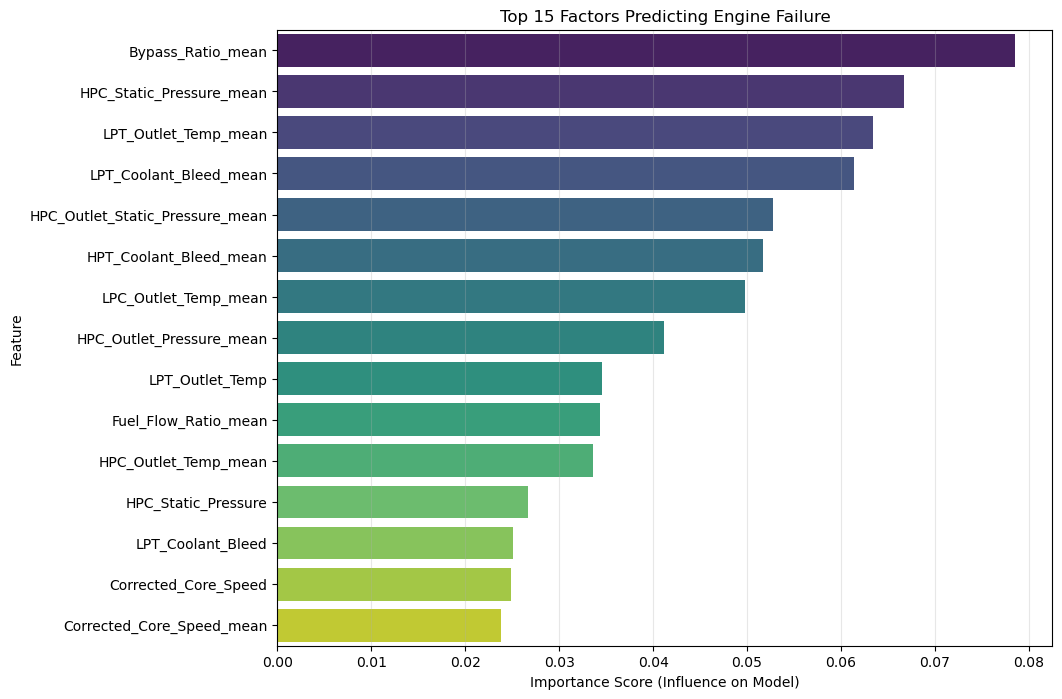

Top 3 Predictive Features:
                     Feature  Importance
35         Bypass_Ratio_mean    0.078576
31  HPC_Static_Pressure_mean    0.066724
24      LPT_Outlet_Temp_mean    0.063417


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# --- 1. CONFIGURATION ---
# Use the best parameters found in tuning. 
# If you skipped tuning, these are robust defaults for C-MAPSS.
params = best_params if 'best_params' in locals() else {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'class_weight': 'balanced',
    'random_state': 42
}

print(f"Training Final Model with params: {params}")

# --- 2. TRAIN FINAL MODEL ---
final_model = RandomForestClassifier(**params, n_jobs=-1)
final_model.fit(X_train, y_train)

# --- 3. FEATURE IMPORTANCE VISUALIZATION ---
# Get importance values
importances = final_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy sorting
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15) # Top 15 only

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title("Top 15 Factors Predicting Engine Failure")
plt.xlabel("Importance Score (Influence on Model)")
plt.grid(axis='x', alpha=0.3)
plt.show()

# --- 4. INTERPRETATION ---
print("Top 3 Predictive Features:")
print(feature_df.head(3))

--- Final Model Performance ---
              precision    recall  f1-score   support

     Healthy       0.97      0.99      0.98      3450
     Warning       0.69      0.58      0.63       300
    Critical       0.90      0.88      0.89       320

    accuracy                           0.95      4070
   macro avg       0.86      0.82      0.84      4070
weighted avg       0.95      0.95      0.95      4070



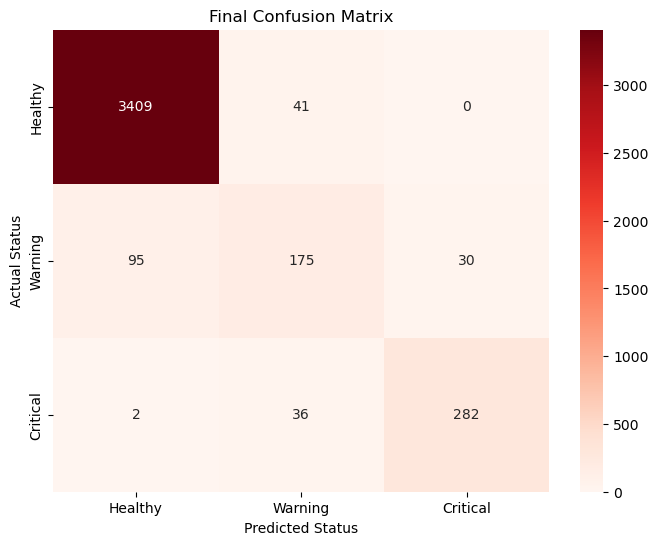

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. PREDICT ON TEST SET ---
y_pred_final = final_model.predict(X_test)

# --- 2. CLASSIFICATION REPORT ---
print("--- Final Model Performance ---")
print(classification_report(y_test, y_pred_final, target_names=['Healthy', 'Warning', 'Critical']))

# --- 3. CONFUSION MATRIX VISUALIZATION ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Healthy', 'Warning', 'Critical'], 
            yticklabels=['Healthy', 'Warning', 'Critical'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Final Confusion Matrix')
plt.show()

In [38]:
import joblib
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# --- 1. CONFIGURATION ---
filename = 'engine_failure_rf_model.pkl'

# --- 2. TRAIN & SAVE (If model is missing) ---
if not os.path.exists(filename):
    print(f"⚠️ Model file not found. Training new model...")
    
    # Check if training data exists in memory
    if 'X_train' in locals() and 'y_train' in locals():
        # Train
        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        # Save
        joblib.dump(rf, filename)
        print(f"✅ Model saved as '{filename}'")
    else:
        print("❌ Error: Training data (X_train) not found. Please re-run the Train/Test Split code.")

# --- 3. LOAD MODEL ---
if os.path.exists(filename):
    loaded_model = joblib.load(filename)
    print(f"✅ Model loaded successfully.")

    # --- 4. SIMULATION (Only if we have test data) ---
    if 'X_test' in locals():
        # Pick a random engine cycle from the test set
        random_idx = np.random.randint(0, len(X_test))
        sample_data = X_test.iloc[random_idx].values.reshape(1, -1)
        true_label = y_test.iloc[random_idx]

        # Predict
        pred = loaded_model.predict(sample_data)[0]
        prob = loaded_model.predict_proba(sample_data)[0][pred] * 100

        # Formatting for display
        status_map = {0: 'HEALTHY', 1: 'WARNING', 2: 'CRITICAL'}
        color_map = {0: '\033[92m', 1: '\033[93m', 2: '\033[91m'} # Green, Yellow, Red
        reset = '\033[0m'

        # Output
        print("\n" + "="*40)
        print("   LIVE ENGINE MONITORING DASHBOARD")
        print("="*40)
        print(f"Sensor Input ID: {random_idx}")
        print("-" * 40)
        print(f"AI Prediction:  {color_map[pred]} {status_map[pred]} {reset}")
        print(f"Confidence:     {prob:.1f}%")
        print(f"Actual Status:  {status_map[true_label]}")
        print("-" * 40)
        
        if pred == 2:
            print("🚨 ALERT: IMMEDIATE INSPECTION REQUIRED")
        elif pred == 1:
            print("⚠️ ALERT: SCHEDULE MAINTENANCE SOON")
        else:
            print("✅ STATUS: OPERATIONAL")
            
    else:
        print("⚠️ X_test not found. Cannot run simulation.")
else:
    print("❌ Critical Error: Model could not be created.")

⚠️ Model file not found. Training new model...
✅ Model saved as 'engine_failure_rf_model.pkl'
✅ Model loaded successfully.

   LIVE ENGINE MONITORING DASHBOARD
Sensor Input ID: 1457
----------------------------------------
AI Prediction:   HEALTHY 
Confidence:     100.0%
Actual Status:  HEALTHY
----------------------------------------
✅ STATUS: OPERATIONAL


C:\Users\sreer\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sreer\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
